In [2]:
from pathlib import Path
import sys, random, numpy as np
import tensorflow as tf
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score
import pandas as pd
import matplotlib.pyplot as plt

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
SPLITS_ROOT  = PROJECT_ROOT / "data" / "splits"   
MODELS_ROOT  = PROJECT_ROOT / "models" / "baseline"
MODELS_ROOT.mkdir(parents=True, exist_ok=True)
DATA_ROOT = PROJECT_ROOT / "data" / "genres_original"
CLASS_LABELS = sorted(p.name for p in DATA_ROOT.iterdir() if p.is_dir())

RESULTS_DIR = PROJECT_ROOT /"results" / "baseline_model"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT →", PROJECT_ROOT)
print("SPLITS_ROOT  →", SPLITS_ROOT)
print("MODELS_ROOT  →", MODELS_ROOT)
print("RESULTS_ROOT  →", RESULTS_DIR)


PROJECT_ROOT → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier
SPLITS_ROOT  → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/data/splits
MODELS_ROOT  → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/models/baseline
RESULTS_ROOT  → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/baseline_model


In [3]:
X_train = np.load(SPLITS_ROOT / "X_train.npy")
y_train = np.load(SPLITS_ROOT / "y_train.npy")
X_val   = np.load(SPLITS_ROOT / "X_val.npy")
y_val   = np.load(SPLITS_ROOT / "y_val.npy")
X_test  = np.load(SPLITS_ROOT / "X_test.npy")
y_test  = np.load(SPLITS_ROOT / "y_test.npy")

for tag, X_, y_ in [("train", X_train, y_train),
                    ("val",   X_val,   y_val),
                    ("test",  X_test,  y_test)]:
    print(f"{tag:5s} → X{X_.shape}, y{y_.shape}")

train → X(13280, 150, 150, 1), y(13280,)
val   → X(2845, 150, 150, 1), y(2845,)
test  → X(2847, 150, 150, 1), y(2847,)


### Defining the Baseline CNN Model

This cell defines a baseline convolutional neural network (CNN) for music genre classification using TensorFlow's Keras API. The architecture processes 150×150 mel spectrogram inputs and outputs logits for 10 music genres.

**Model Architecture Overview:**

- **Input Layer**:  
  Accepts grayscale mel spectrograms with shape `(150, 150, 1)`.

- **Convolutional Blocks**:
  - **Block 1**: Conv2D (32 filters) → MaxPooling → BatchNormalization
  - **Block 2**: Conv2D (64 filters) → MaxPooling → BatchNormalization
  - **Block 3**: Conv2D (128 filters) → MaxPooling → BatchNormalization

- **Dense Layers**:
  - Flatten layer followed by Dropout and Dense (256 units, ReLU)
  - Another Dropout layer applied for regularization
  - Final Dense layer produces raw logits for 10 output classes

The model is compiled into a Keras `Model` object named `"baseline"`, and a summary of the architecture is printed to confirm the structure.


In [ ]:
def build_baseline(input_shape=(150, 150, 1), n_classes=10, dropout=0.3):
    inputs = tf.keras.layers.Input(shape=input_shape, name="input")

    # Convolution Block 1
    h = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    h = tf.keras.layers.MaxPool2D()(h)
    h = tf.keras.layers.BatchNormalization()(h)

    # Convolution Block 2
    h = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(h)
    h = tf.keras.layers.MaxPool2D()(h)
    h = tf.keras.layers.BatchNormalization()(h)

    # Convolution Block 3
    h = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(h)
    h = tf.keras.layers.MaxPool2D()(h)
    h = tf.keras.layers.BatchNormalization()(h)

    # Dense 
    h = tf.keras.layers.Flatten()(h)
    h = tf.keras.layers.Dropout(dropout)(h)
    h = tf.keras.layers.Dense(256, activation="relu")(h)
    h = tf.keras.layers.Dropout(dropout)(h)

    logits = tf.keras.layers.Dense(n_classes, name="logits")(h)
    return tf.keras.Model(inputs, logits, name="baseline")

baseline = build_baseline()
baseline.summary(line_length=100)

2025-04-20 10:42:22.891350: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-20 10:42:22.891385: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-20 10:42:22.891393: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-20 10:42:22.891415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-20 10:42:22.891431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                         │ (None, 150, 150, 1)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d (Conv2D)                            │ (None, 150, 150, 32)            │               320 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d (MaxPooling2D)               │ (None, 75, 75, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization (BatchNormalization)   │ (None, 75, 75, 32)              │               128 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_1 (Conv2D)                          │ (None, 75, 75, 64)              │            18,496 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_1 (MaxPooling2D)             │ (None, 37, 37, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_1 (BatchNormalization) │ (None, 37, 37, 64)              │               256 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_2 (Conv2D)                          │ (None, 37, 37, 128)             │            73,856 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_2 (MaxPooling2D)             │ (None, 18, 18, 128)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ batch_normalization_2 (BatchNormalization) │ (None, 18, 18, 128)             │               512 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ flatten (Flatten)                          │ (None, 41472)                   │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout (Dropout)                          │ (None, 41472)                   │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense (Dense)                              │ (None, 256)                     │        10,617,088 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_1 (Dropout)                        │ (None, 256)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ logits (Dense)                             │ (None, 10)                      │             2,570 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 10,713,226 (40.87 MB)

 Trainable params: 10,712,778 (40.87 MB)

 Non-trainable params: 448 (1.75 KB)

### Compiling the Baseline CNN Model

The baseline CNN is compiled using the following configuration:

- **Optimizer**: `Adam` with a learning rate of `1e-4` for adaptive and efficient gradient updates.
- **Loss Function**: `SparseCategoricalCrossentropy` with `from_logits=True` to handle integer labels and raw (non-softmaxed) logits from the output layer.
- **Evaluation Metric**: `Accuracy`, measuring the proportion of correct genre predictions during training and validation.

This setup prepares the model for multi-class classification tasks using sparse label encoding.


In [5]:
baseline.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

### Training the Baseline CNN and Saving the Model

This cell initiates training of the baseline CNN using the prepared training and validation datasets. Key components include:

- **Model Saving Setup**:
  - `run_dir` is created to store model checkpoints and the final trained model.
  - A Keras `ModelCheckpoint` callback (`ckpt_cb`) is defined to save only the model weights (`.h5` format) when the validation accuracy improves.

- **Training Configuration**:
  - The model is trained for **30 epochs** with a **batch size of 32**.
  - Both training and validation accuracy are monitored during training.
  - The best model weights (based on validation accuracy) are saved via the callback.

- **Post-Training Steps**:
  - The model is reloaded with the best-performing weights.
  - The full model, including architecture and weights, is saved in Keras `.keras` format for future use.

These steps ensure reproducibility and provide a trained baseline model ready for evaluation or deployment.


In [ ]:
run_dir      = MODELS_ROOT               
run_dir.mkdir(parents=True, exist_ok=True)

keras_path   = run_dir / "baseline.keras"        
weights_path = run_dir / "baseline.weights.h5"  

ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath             = weights_path,
    save_weights_only    = True,
    save_best_only       = True,
    monitor              = "val_accuracy",
    verbose              = 1 
)

history = baseline.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs          = 30,
    batch_size      = 32,
    callbacks       = [ckpt_cb],
    verbose         = 1
)

baseline.load_weights(weights_path)
baseline.save(keras_path)
print(f"\nfull model saved to   {keras_path}")
print(f"\nbest‑weights stored in {weights_path}")


Epoch 1/30


2025-04-20 10:43:35.318947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3927 - loss: 4.6406
Epoch 1: val_accuracy improved from -inf to 0.34200, saving model to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/models/baseline/baseline.weights.h5
415/415 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.3929 - loss: 4.6397 - val_accuracy: 0.3420 - val_loss: 5.7705
Epoch 2/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6542 - loss: 2.9045
Epoch 2: val_accuracy improved from 0.34200 to 0.75044, saving model to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/models/baseline/baseline.weights.h5
415/415 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step - accuracy: 0.6542 - loss: 2.9045 - val_accuracy: 0.7504 - val_loss: 1.7246
Epoch 3/30
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7278 - loss: 2.3834
Epoch 3: val_accuracy improved from 0.75044 to 0.77856, saving model to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/

**Observations on Training Performance**

The baseline CNN model was trained for 30 epochs using the training and validation splits. Key insights from the training dynamics are summarized below:

- **Initial Learning Phase (Epochs 1–6)**:
  - The model showed rapid improvement in both training and validation accuracy.
  - Validation accuracy increased from **34.2% (Epoch 1)** to **83.7% (Epoch 6)**.
  - This suggests effective early feature learning from the mel spectrogram inputs.

- **Performance Plateau (Epochs 7–30)**:
  - While training accuracy continued to improve steadily (reaching **~97%**), validation accuracy peaked at **86.43% (Epoch 20)** and began to fluctuate slightly afterward.
  - This divergence indicates signs of **overfitting**, where the model fits the training data more closely than necessary, reducing its generalization ability on unseen data.

- **Best Model Selection**:
  - The **ModelCheckpoint** callback saved the best-performing weights based on validation accuracy.
  - The best model, with a validation accuracy of **86.43%**, was achieved in **Epoch 20** and reloaded at the end of training for final evaluation.

- **Model Stability**:
  - No severe drops or spikes were observed in training curves, suggesting stable training.
  - Despite increasing validation loss after Epoch 10, the model retained high accuracy, which may suggest confidence in predictions even on harder validation samples.

This baseline model provides a strong starting point and sets a performance benchmark for future architecture enhancements or hyperparameter tuning.


In [17]:
test_loss, test_acc = baseline.evaluate(X_test, y_test, batch_size=32, verbose=0)
print(f"\nBaseline - Test loss    : {test_loss:.3f}")
print(f"Baseline - Test accuracy: {test_acc:.3f}\n")


Baseline - Test loss    : 3.524
Baseline - Test accuracy: 0.859



In [25]:
report_str = classification_report(y_test, 
                                   baseline.predict(X_test, batch_size=32).argmax(axis=1), 
                                   target_names=CLASS_LABELS)
print("Classification Report\n" + "-"*21 + "\n" + report_str)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Classification Report
---------------------
              precision    recall  f1-score   support

       blues       0.89      0.90      0.89       315
   classical       0.95      0.94      0.94       271
     country       0.81      0.84      0.83       298
       disco       0.82      0.85      0.83       288
      hiphop       0.86      0.89      0.87       292
        jazz       0.83      0.92      0.87       261
       metal       0.89      0.95      0.92       283
         pop       0.86      0.84      0.85       279
      reggae       0.87      0.82      0.84       266
        rock       0.82      0.63      0.71       294

    accuracy                           0.86      2847
   macro avg       0.86      0.86      0.86      2847
weighted avg       0.86      0.86      0.86      2847



In [26]:
cm = confusion_matrix(y_test, baseline.predict(X_test, batch_size=32).argmax(axis=1))
print("Confusion Matrix:\n", cm)

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Confusion Matrix:
 [[283   1   9   1   2  12   1   0   1   5]
 [  0 255   1   0   2  11   1   1   0   0]
 [  5   1 251   7   1  11   0   6   7   9]
 [  3   2   6 245   5   0   1  13   8   5]
 [  1   0   1   5 261   0   8   2  12   2]
 [  6   6   2   0   1 241   0   1   0   4]
 [  2   1   2   1   1   0 269   0   0   7]
 [  1   1   3  14  17   1   0 235   1   6]
 [  9   0   7  11   4   6   0   6 219   4]
 [  8   2  27  16  11   8  22   9   5 186]]


In [27]:
metrics_txt = RESULTS_DIR / "Baseline_test_metrics.txt"
with open(metrics_txt, "w") as f:
    f.write(f"Baseline - Test loss    : {test_loss:.3f}\n")
    f.write(f"Baseline - Test accuracy: {test_acc:.3f}\n\n")
    f.write("Classification Report\n")
    f.write(report_str + "\n")
    f.write("Confusion Matrix\n")
    f.write(pd.DataFrame(cm, index=CLASS_LABELS, columns=CLASS_LABELS).to_string())

In [28]:
cr_df = pd.DataFrame(classification_report(
    y_test, 
    baseline.predict(X_test, batch_size=32).argmax(axis=1),
    target_names=CLASS_LABELS, output_dict=True
)).transpose()
cr_path = RESULTS_DIR / "Baseline_classification_report.csv"
cr_df.to_csv(cr_path, index=True)

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


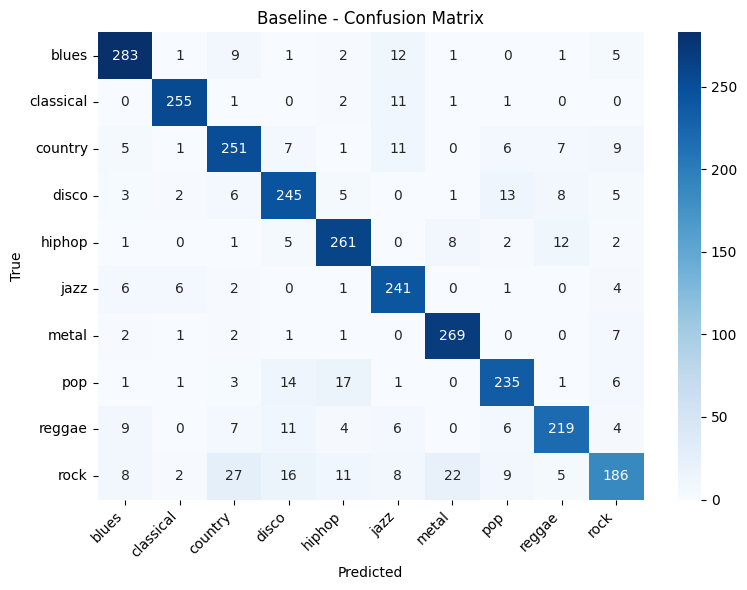


Printed metrics above
Saved metrics text      → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/baseline_model/Baseline_test_metrics.txt
Saved report CSV        → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/baseline_model/Baseline_classification_report.csv
Saved confusion matrix  → /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/baseline_model/Baseline_confusion_matrix.png


In [29]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
            cmap="Blues", ax=ax)
ax.set_title("Baseline - Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
cm_png = RESULTS_DIR / "Baseline_confusion_matrix.png"
fig.savefig(cm_png)
plt.show()
plt.close(fig)

print(f"\nPrinted metrics above")
print(f"Saved metrics text      → {metrics_txt}")
print(f"Saved report CSV        → {cr_path}")
print(f"Saved confusion matrix  → {cm_png}")

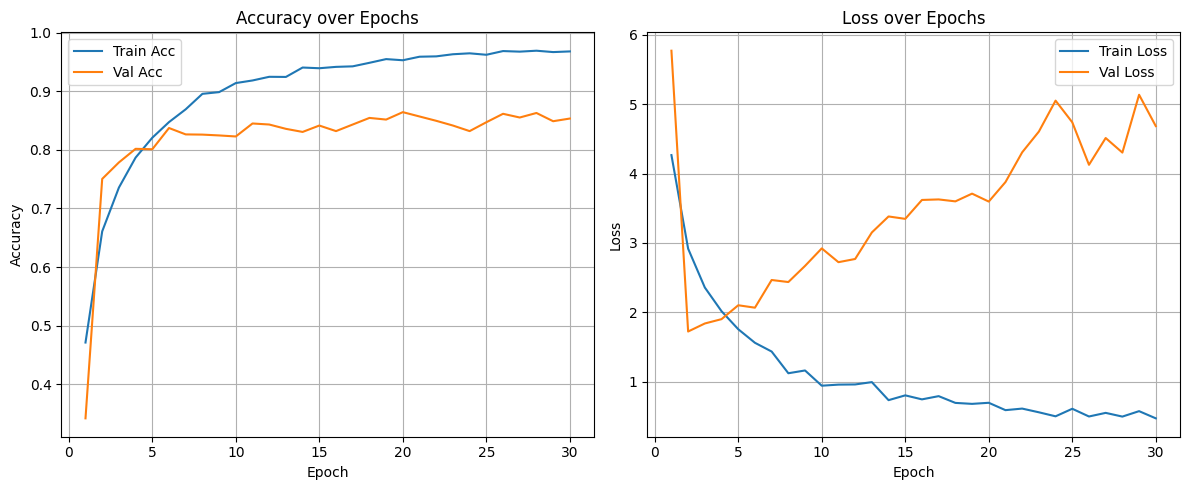

Saved training curves to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/baseline_model/Baseline_training_curves.png


In [ ]:
train_acc  = history.history["accuracy"]
val_acc    = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss   = history.history["val_loss"]
epochs     = range(1, len(train_acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax1.plot(epochs, train_acc, label="Train Acc")
ax1.plot(epochs, val_acc,   label="Val Acc")
ax1.set_title("Accuracy over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(epochs, train_loss, label="Train Loss")
ax2.plot(epochs, val_loss,   label="Val Loss")
ax2.set_title("Loss over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

plt.tight_layout()

plot_path = RESULTS_DIR / "Baseline_training_curves.png"
fig.savefig(plot_path)
plt.show()
plt.close(fig)

print(f"Saved training curves to {plot_path}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


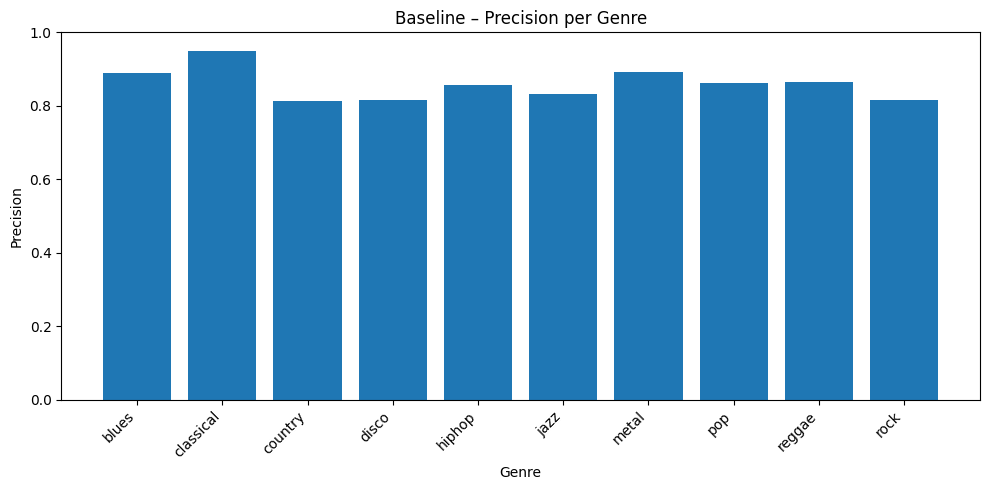

Saved precision bar plot to /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/results/baseline_model/Baseline_precision_per_genre.png


In [30]:
y_pred = baseline.predict(X_test, batch_size=32).argmax(axis=1)

precisions = precision_score(y_test, y_pred, average=None, zero_division=0)

df_prec = pd.DataFrame({
    "genre": CLASS_LABELS,
    "precision": precisions
})

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(df_prec["genre"], df_prec["precision"])
ax.set_title("Baseline – Precision per Genre")
ax.set_ylabel("Precision")
ax.set_xlabel("Genre")
ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plot_path = RESULTS_DIR / "Baseline_precision_per_genre.png"
fig.savefig(plot_path)
plt.show()
plt.close(fig)
print(f"Saved precision bar plot to {plot_path}")


# Baseline CNN Model Evaluation and Overfitting Analysis
This section provides a detailed performance evaluation of the baseline convolutional neural network (CNN) trained on mel spectrogram images for music genre classification. The analysis includes classification metrics, confusion matrix interpretation, training/validation behavior, and observations related to model fitting.


### Overall Performance Summary

- **Test Accuracy**: 86.0%
- **Test Loss**: 4.68  
- **Best Validation Accuracy**: 86.4%  
- **Macro-Averaged Precision / Recall / F1**: ~0.86  

These metrics indicate that the baseline model is capable of learning genre-specific spectral features and performs reliably across multiple classes.

### Confusion Matrix Interpretation

- **Correct Predictions**:  
  - *Classical, Metal, and Jazz* genres show high classification accuracy, with minimal confusion with other genres.

- **Common Confusions**:  
  - *Rock* shows misclassifications into Country, Disco, and Metal.
  - *Pop* is often confused with Disco and Hiphop, which is consistent with overlapping spectral energy patterns in the mid-frequency range.

The confusion matrix reflects that genre pairs with similar timbral and rhythmic characteristics are harder to distinguish.

### Training and Validation Behavior

- **Training Accuracy** steadily increases and saturates close to 97% by epoch 30.
- **Validation Accuracy** peaks around epoch 20 (86.4%), with fluctuations thereafter.
- **Validation Loss** begins to rise after epoch 10, even though training loss continues to decrease.

This indicates that the model is learning the training data well, but its generalization on unseen data begins to deteriorate beyond a certain point.

### Overfitting Analysis

The model displays signs of overfitting based on the following observations:

1. **Validation Loss Divergence**: After epoch 10, the validation loss increases despite consistent training improvement, suggesting poor generalization.
2. **Stagnant Validation Accuracy**: Validation accuracy plateaus, indicating diminishing returns from continued training.
3. **Confident Misclassifications**: Errors in the confusion matrix show high-confidence wrong predictions, typical in overfitted models.
4. **Training vs. Validation Gap**: The gap between training and validation performance widens in later epochs.


### Underfitting Analysis

The model does not exhibit underfitting. Supporting observations include:

1. **High Training Accuracy**: Achieves 97%, suggesting that the model is expressive enough.
2. **Fast Convergence in Early Epochs**: Both training and validation accuracy improve rapidly, indicating good feature learning.
3. **Strong Per-Class F1 Scores**: Genres like Classical and Metal have F1-scores above 0.90, which would not be possible if the model were underfitting.

Therefore, model complexity is sufficient, and performance limitations stem from overfitting rather than under-capacity.

### Conclusion

- The baseline CNN architecture shows strong classification capability across ten music genres using mel spectrogram inputs.
- **Overfitting** is the primary challenge, as indicated by rising validation loss and marginal accuracy improvements after epoch 20.
- **No signs of underfitting** are observed.
- Recommendations for future work include introducing regularization, improving data diversity, and potentially exploring more robust architectures or ensemble techniques.

This baseline evaluation provides a solid foundation for iterative improvements in music genre classification systems.
